### STATS 202 
Waseh Ahmad
Summer 2019

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [115]:
#import statements
# import matplotlib.pyplot as plt
# from matplotlib.colors import Colormap
import random
import matplotlib
# matplotlib.use('Agg') # set the backend before importing pyplot

import matplotlib.pyplot as plt # etc. etc.

from matplotlib.colors import Colormap
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
import sklearn
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,LeaveOneOut,cross_validate, GridSearchCV
from sklearn import linear_model, kernel_ridge
from statsmodels.graphics.gofplots import ProbPlot
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize, scale, PolynomialFeatures
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
import xgboost as xgb
import patsy
import library
from mpl_toolkits.mplot3d import Axes3D


warnings.filterwarnings('ignore')

### Load Data and variables

In [4]:
#load all studies
files = ['Study_A.csv','Study_B.csv','Study_C.csv','Study_D.csv','Study_E.csv']
trials = []
for file in files:
    trials.append(pd.read_csv(file))
    
allTrialsDF = pd.concat(trials)

#ERROR value in 'Country' variable needs to be corrected
#60014 --> USA
#60025 --> Russia
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60014)] = "USA"
allTrialsDF['Country'][(allTrialsDF.Country == "ERROR") & (allTrialsDF.SiteID==60025)] = "RUSSIA"


#Create dummy variables for Study
allTrialsDF['TxGroup'] = pd.factorize(allTrialsDF.TxGroup)[0]
countryDummies = pd.get_dummies(allTrialsDF.Country,drop_first=True,prefix='Country')
studyDummies = pd.get_dummies(allTrialsDF.Study,drop_first=True,prefix='Study')
# allTrialsDF = allTrialsDF.drop(['Country','Study'],axis=1)

allTrialsDF = pd.concat([allTrialsDF,countryDummies,studyDummies],axis=1)

#change lead status to binary values
factors = {'Passed': 0, 'Flagged': 1,'Assign to CS':1}
allTrialsDF['LeadStatus'].replace(factors,inplace = True)

In [5]:
#get ids of the users for whom we need to make predictions/classification
submissionIDs = pd.read_csv("sample_submission_PANSS.csv").PatientID

In [6]:
# add variables for lag, diff, sums of (p,n,g)

#sort the data by patient and visits
allSortedDF = allTrialsDF.sort_values(['PatientID', 'VisitDay'], ascending=[True, True]).reset_index().drop(['index'],axis=1)

# Add relative visit day variable
for name,group in allSortedDF.groupby('PatientID').__iter__():
    idx = 0
    for row_index,row in group.iterrows():
        allSortedDF.at[row_index,'RelativeVisitDay'] = idx
        idx+=1

#get sum of Ps,Ns,Gs
Ps=['P1', 'P2', 'P3', 'P4', 'P5','P6', 'P7']
Gs=['G1','G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15','G16']
Ns=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']
allSortedDF['Ps'] = allSortedDF[Ps].sum(axis=1)
allSortedDF['Gs'] = allSortedDF[Gs].sum(axis=1)
allSortedDF['Ns'] = allSortedDF[Ns].sum(axis=1)

#diff of PANSS_Total
allSortedDF['PANSS_Total_diff_1'] = allSortedDF.groupby('PatientID')['PANSS_Total'].diff().fillna(0)

#get first lags for PANSS, Ps, Gs, Ns
for col in ['Ps','Ns','Gs','PANSS_Total','PANSS_Total_diff_1']:
    newCol = col+"_lag_1"
    allSortedDF[newCol] = allSortedDF.groupby('PatientID')[col].shift(1)

In [115]:
allSortedDF.columns

Index(['AssessmentiD', 'Country', 'G1', 'G10', 'G11', 'G12', 'G13', 'G14',
       'G15', 'G16', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9',
       'LeadStatus', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'PANSS_Total', 'PatientID', 'RaterID',
       'SiteID', 'Study', 'TxGroup', 'VisitDay', 'Country_Australia',
       'Country_Austria', 'Country_Belgium', 'Country_Brazil',
       'Country_Bulgaria', 'Country_Canada', 'Country_China',
       'Country_Czech Republic', 'Country_France', 'Country_Germany',
       'Country_Greece', 'Country_Hungary', 'Country_India', 'Country_Japan',
       'Country_Korea', 'Country_Mexico', 'Country_Poland', 'Country_Portugal',
       'Country_RUSSIA', 'Country_Romania', 'Country_Russia',
       'Country_Slovakia', 'Country_Spain', 'Country_Sweden', 'Country_Taiwan',
       'Country_UK', 'Country_USA', 'Country_Ukraine', 'Study_B', 'Study_C',
       'Study_D', 'Study_E', 'RelativeVisitDay', 'Ps', 'Gs', 'N

In [7]:
formula = "PANSS_Total ~ TxGroup*VisitDay"
olsModel = smf.ols(formula,data=allSortedDF).fit()
olsModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     3791.
Date:                Thu, 08 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:50:41   Log-Likelihood:                -95232.
No. Observations:               22909   AIC:                         1.905e+05
Df Residuals:                   22905   BIC:                         1.905e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           81.4695      0.200    407.855      0.000      81.078      81.861
TxGroup              0.3672      0.284      1.292      0.197      -0.190       0.924
VisitDay            -0.1161      0.002    -74.809      0.000      -0.119      -0.113
TxGroup:VisitDay    -0.0022      0.002     -0.995      0.320      -0.006       0.002
==============================================================================
Omnibus:                      420.844   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.151
Skew:                           0.289   Prob(JB):                    2.01e-105
Kurtosis:                       3.412   Cond. No.                         470.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Patient Segmentation

In [6]:
firstVisits = allSortedDF.groupby('PatientID').first()[['PANSS_Total','Ps','Gs','Ns']]
# normalize the data and create a df out of it
firstVisitsScaled = normalize(firstVisits,axis=0)
firstVisitsScaledDF = pd.DataFrame(firstVisitsScaled, columns=firstVisits.columns)


labels = firstVisits.index.values
linked = hierarchy.linkage(firstVisitsScaledDF, 'complete',metric='euclidean')


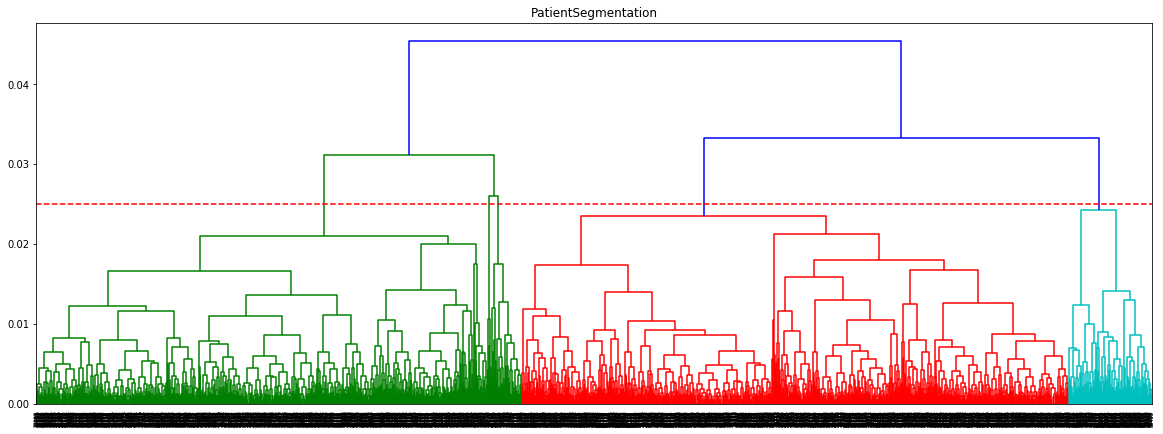

In [7]:
plt.figure(figsize=(20, 7))  
dendrogram = hierarchy.dendrogram(linked,labels=labels)
plt.title("PatientSegmentation")
plt.axhline(y=0.025, color='r', linestyle='--')
plt.show() 

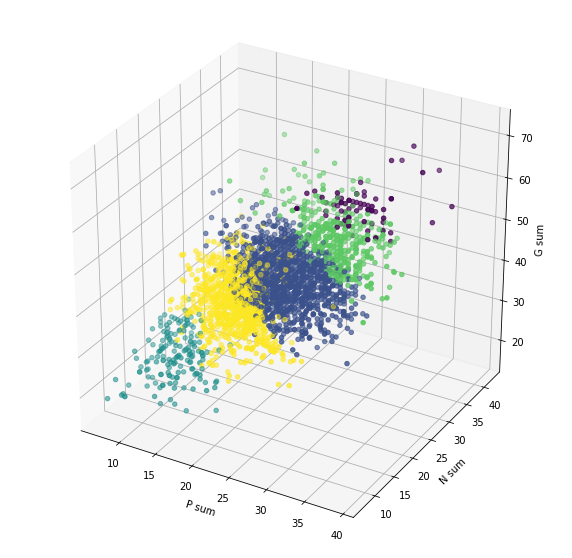

In [8]:
numClusters = 5
aggClustering = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='complete')
aggClusteringFit = aggClustering.fit_predict(firstVisits)

# %matplotlib notebook
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=aggClustering.labels_, cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()


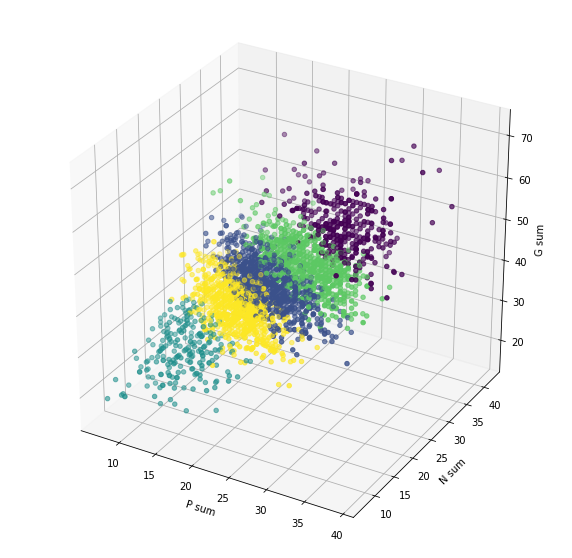

In [9]:
kNNCenters = []
#get centers from previous clustering
for k in np.unique(aggClusteringFit):
    #for each parameter
    kthMeans = []
    for p in firstVisits.columns:
        #compute mean
        kthMeans.append(np.mean(firstVisits[p].loc[aggClustering.labels_ == k]))
    kNNCenters.append(np.asarray(kthMeans))
    
kMeansClusters = KMeans(n_clusters=numClusters,init=np.asarray(kNNCenters),random_state=1).fit(firstVisits)

#plot
fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(firstVisits.Ps,firstVisits.Ns, firstVisits.Gs, c=kMeansClusters.labels_,cmap='viridis_r', marker='o')
# fig.colorbar(img)

ax.set_xlabel('P sum')
ax.set_ylabel('N sum')
ax.set_zlabel('G sum')

plt.show()

# Forecasting

In [66]:
#divide set into training and test data

#first, get all the possible attributes that we might want
studies = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Study")== True])
X = ['TxGroup','VisitDay','RelativeVisitDay','PANSS_Total_lag_1','PANSS_Total_diff_1_lag_1','RaterID']+studies
# X = ['TxGroup','RelativeVisitDay','VisitDay','PANSS_Total_lag_1']+studies
y = ['PANSS_Total']

#remove first visits as we cannot use that to make predictions (there is no previous data on it)
# removeFirstVisits = allSortedDF.loc[allSortedDF.RelativeVisitDay != 0]
removeFirstVisits['RaterID'] = pd.factorize(removeFirstVisits['RaterID'])[0]

xSet = removeFirstVisits[X]
ySet = removeFirstVisits[y]
xTrain, xTest, yTrain, yTest = train_test_split(xSet, ySet, test_size=0.25, random_state=123456)
trainDF = pd.concat([xTrain,yTrain],axis=1)



In [7]:
#make the prediction by first making the df for the features being used
extraCols = ['PANSS_Total_diff_1','PANSS_Total']
submissionXDF = allSortedDF.loc[allSortedDF.PatientID.isin(submissionIDs)][X+['PatientID']+extraCols]
submissionXDF = submissionXDF.groupby('PatientID').last()
for col in extraCols:
    submissionXDF[col+"_lag_1"] = submissionXDF[col]
submissionXDF = submissionXDF.drop(extraCols,axis=1)


In [ ]:
#try linear regression
testMSEs = list()
trainMSEs = list()
for degree in range(1,7,1):
    trainFeatures = PolynomialFeatures(degree).fit_transform(xTrain)
    testFeatures = PolynomialFeatures(degree).fit_transform(xTest)
    linearModel = linear_model.LinearRegression().fit(trainFeatures,yTrain)
    #training MSE
    yPredTrainLM = linearModel.predict(trainFeatures)
    trainMSEs.append(library.GetMSE(yPredTrainLM,yTrain).values[0])
    #Test MSE
    yPredTestLM = linearModel.predict(testFeatures)
    testMSEs.append(library.GetMSE(yPredTestLM,yTest).values[0])


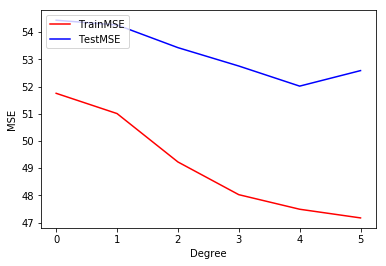

In [12]:
plt.plot(range(6),trainMSEs,c='red',label='TrainMSE')
plt.plot(range(6),testMSEs, c='blue',label='TestMSE')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.legend(loc='upper left')

In [ ]:
# #make the prediction by first making the df for the features being used
# inputDF = initialDF.loc[initialDF.PatientID.isin(idsToForecast)]
# # groupedDF = pd.DataFrame({'TxGroup':sortedDF.groupby('PatientID').TxGroup.agg(pd.Series.mode),'PANSS_diff_avg':sortedDF.groupby('PatientID').mean().PANSS_Total_diff})
# inputDF = inputDF.groupby('PatientID').last()
# inputDF.PANSS_Lag1 = inputDF.PANSS_Total 
# inputDF = inputDF.drop(['PANSS_Total'],axis=1)


# yPred = modelFit.predict(inputDF)

# submission = pd.DataFrame(yPred)
# # submission.to_csv("forecast_submit.csv")

# yPredLasso = lassoModelFit.predict(library.InjectFactors(inputDF,factorVars))
# submission = pd.DataFrame(yPredLasso)
# submission['PatientID'] = idsToForecast
# # submission.to_csv("forecast_submit_Lasso.csv",header=['PatientID','PANSS_Total'])

In [39]:
# Bagging approach

np.random.seed(5)
baseModel = DecisionTreeRegressor(random_state=1,max_leaf_nodes=32)
baggingModel = Pipeline([
  ('transformation', PolynomialFeatures(1)),
  ('feature_selection', RFE(baseModel,n_features_to_select=2)),
  ('regression', BaggingRegressor(base_estimator=baseModel,n_estimators=1000))
])
# baggingModelFit = baggingModel.fit(library.InjectFactors(xTrain,factorVars),yTrain)
#run CV on pipeline
# scores = cross_validate(baggingModel, PolynomialFeatures(4).fit_transform(library.InjectFactors(xTrain,factorVars)),yTrain, cv=5,scoring='neg_mean_squared_error',return_estimator=True)

#degree = 1 has better time with a slightly worse MSE (0.09)
param0 = {'transformation__degree':[1,2]}
# n_features to select = 2 , for simplicity. not much improvement from more
param1 = {'feature_selection__n_features_to_select':[1,2,4,8,16,32]}

#max leaf nodes = 16, n_estimators = 1000
param2 = {'regression__base_estimator__max_leaf_nodes':[2,4,8,16,32],
          'regression__n_estimators':[10,100,1000,3000]}

#uncomment the followign line to run the tuning
# tuneOutput = GridSearchCV(baggingModel, param2, scoring='neg_mean_squared_error', cv=4).fit(xTrain,yTrain)

<ErrorbarContainer object of 3 artists>

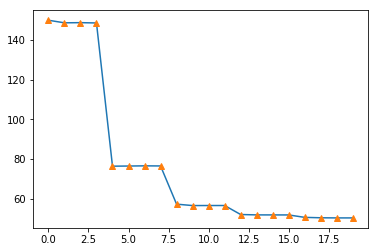

In [40]:
results = pd.DataFrame(tuneOutput.cv_results_)
plt.plot(range(len(results)),np.abs(results.mean_test_score))
plt.errorbar(range(len(results)),np.abs(results.mean_test_score),linestyle='None', marker='^')

# print("Features To select:"+str(results.iloc[12].param_feature_selection__n_features_to_select))
# print("Number of Polynomials:"+str(results.iloc[12].param_transformation__degree))

In [54]:
baggingModel.set_params(feature_selection__n_features_to_select=2, transformation__degree=1,regression__base_estimator__max_leaf_nodes=16,regression__n_estimators=1000)
baggingModelFit = baggingModel.fit(xTrain,yTrain)  
yPredTrain = baggingModelFit.predict(xTrain)
yPredTest = baggingModelFit.predict(xTest)
print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))


Train MSE:50.91456156657022
Test MSE:54.46099120011082


In [37]:
# #create a set of predictions
# baggingModelFit = baggingModel.fit(PolynomialFeatures(4).fit_transform(library.InjectFactors(xTrain,factorVars)),yTrain)
# predictions = baggingModelFit.predict(PolynomialFeatures(4).fit_transform(library.InjectFactors(inputDF,factorVars)))

# submission = pd.DataFrame(predictions)
# submission['PatientID'] = idsToForecast
# submission.to_csv("forecast_submit_Bagging.csv",header=['PatientID','PANSS_Total'])

In [16]:
yPredTrain = xgbModelFit.predict(xTrain)
yPredTest = xgbModelFit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))


# predictions = xgbModelFit.predict(inputDFWithCategories)
# submission = pd.DataFrame(predictions)
# submission['PatientID'] = idsToForecast
# submission.to_csv("forecast_submit_XGB.csv",header=['PANSS_Total','PatientID'])

Train MSE:46.9002237092
Test MSE:51.7819561621


In [52]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_cv(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBRegressor(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='reg:squarederror',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate).fit(xTrain,yTrain)
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_mean_squared_error',cv=4)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}
optimizer = BayesianOptimization(f=xgb_cv,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
# optimizer.maximize(n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_es... | subsample |
-------------------------------------------------------------------------------------------------
|  2        | -52.0     |  0.3461   |  0.008039 |  7.749    |  10.13    |  2.431e+0 |  0.5459   |
|  3        | -49.92    |  0.7083   |  0.007156 |  4.222    |  7.928    |  3.012e+0 |  0.1123   |
|  4        | -49.83    |  0.7878   |  0.008838 |  4.189    |  8.308    |  1.302e+0 |  0.4283   |
|  5        | -49.51    |  0.9305   |  0.006549 |  4.383    |  9.521    |  2.267e+0 |  0.6056   |
|  6        | -49.51    |  0.9338   |  0.005512 |  4.759    |  8.527    |  2.268e+0 |  0.4005   |
|  8        | -49.49    |  0.9327   |  0.005727 |  4.561    |  9.046    |  2.268e+0 |  0.5076   |


In [54]:
print(optimizer.max)

{'target': -49.49335400724976, 'params': {'colsample_bytree': 0.9327168726669024, 'learning_rate': 0.005726562438123513, 'max_depth': 4.560754838168456, 'min_child_weight': 9.045540235624115, 'num_estimators': 2267.629207663803, 'subsample': 0.5075516841270551}}


In [67]:
# xgbModel = xgb.XGBRegressor(learning_rate =0.007822, n_estimators=2000,max_depth=int(3.64),min_child_weight=5.75,
#                                                    objective='reg:squarederror', seed=1)
# xgbGS1Fit = xgbModel.fit(xTrain, yTrain)
max_depth = int(4.560754838168456)
min_child_weight = 9.045540235624115
subsample = 0.5075516841270551
colsample_bytree = 0.9327168726669024
objective = 'reg:squarederror'
num_estimators = int(2267.629207663803)
learning_rate = 0.005726562438123513

boostModel = xgb.XGBRegressor(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict(xTrain)
yPredTest = boostModelFit.predict(xTest)

print("Train MSE:"+str(library.GetMSE(yPredTrain,np.asarray(yTrain.PANSS_Total))))
print("Test MSE:"+str(library.GetMSE(yPredTest,np.asarray(yTest.PANSS_Total))))

Train MSE:44.25041953125252
Test MSE:48.87170577843571


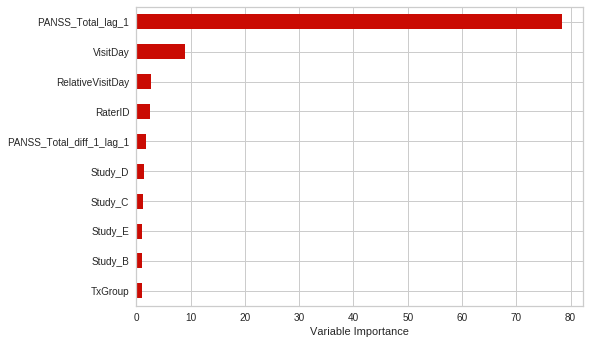

In [68]:
Importance = pd.DataFrame({'Importance':boostModelFit.feature_importances_*100}, index=xTrain.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

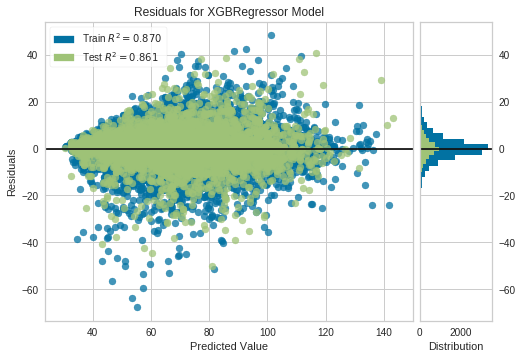

In [69]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(boostModel)

visualizer.fit(xTrain, pd.Series(yTrain.PANSS_Total)) # Fit the training data to the model
visualizer.score(xTest, pd.Series(yTest.PANSS_Total))  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [7]:

predictions = boostModelFit.predict(submissionXDF)
submission = pd.DataFrame(predictions)
submission['PatientID'] = submissionIDs
submission.to_csv("forecast_submit_XGB.csv",header=['PANSS_Total','PatientID'])

NameError: name 'boostModelFit' is not defined

# Classification


In [8]:
def checkMultipleValuesShared(df,group,column):
    print(group+":"+str(sum(df.groupby([group])[column].unique().apply(lambda x:1 if len(x) > 1 else 0))>0))

# check if possible to have multiple studies with same values. 
checkMultipleValuesShared(allSortedDF,'Country','Study')
checkMultipleValuesShared(allSortedDF,'SiteID','Study')
checkMultipleValuesShared(allSortedDF,'PatientID','Study')
checkMultipleValuesShared(allSortedDF,'RaterID','Study')


Country:True
SiteID:False
PatientID:False
RaterID:False


In [231]:
#divide set into training and test data

#first, get all the possible attributes that we might want

# since each patient,site,Rater is unique to the study, cannot use those as features

countries = list(allSortedDF.columns[allSortedDF.columns.str.startswith("Country_")== True])
X = ['TxGroup','VisitDay','RelativeVisitDay','PANSS_Total_lag_1','PANSS_Total_diff_1','PANSS_Total','Ns','Gs']+countries
y = ['LeadStatus']


allSortedDF['PANSS_Total_lag_1'] = allSortedDF['PANSS_Total_lag_1'].fillna(allSortedDF.PANSS_Total)
classificationDF = allSortedDF.loc[allSortedDF['Study_E'] == 0][X+y]
resultDF = allSortedDF.loc[allSortedDF['Study_E'] == 1][X+['AssessmentiD']]

xSet = classificationDF[X]
ySet = classificationDF[y]
xTrain, xTest, yTrain, yTest = train_test_split(xSet, ySet, test_size=0.25, random_state=123456)
trainDF = pd.concat([xTrain,yTrain],axis=1)



In [216]:
# #make the prediction by first making the df for the features being used
# extraCols = ['PANSS_Total_diff_1','PANSS_Total']
# submissionXDF = allSortedDF.loc[allSortedDF.PatientID.isin(submissionIDs)][X+['PatientID']+extraCols]
# submissionXDF = submissionXDF.groupby('PatientID').last()
# for col in extraCols:
#     submissionXDF[col+"_lag_1"] = submissionXDF[col]
# submissionXDF = submissionXDF.drop(extraCols,axis=1)


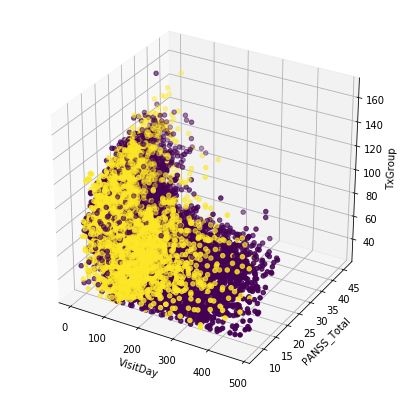

In [76]:
# attempt visualizing the data
%matplotlib inline

fig = plt.figure(figsize=(7,7)) 
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(xSet.VisitDay,xSet.Ns, xSet.PANSS_Total_lag_1, c=list(ySet.LeadStatus), marker='o')
# fig.colorbar(img)

ax.set_xlabel('VisitDay')
ax.set_ylabel('PANSS_Total')
ax.set_zlabel('TxGroup')

plt.show()

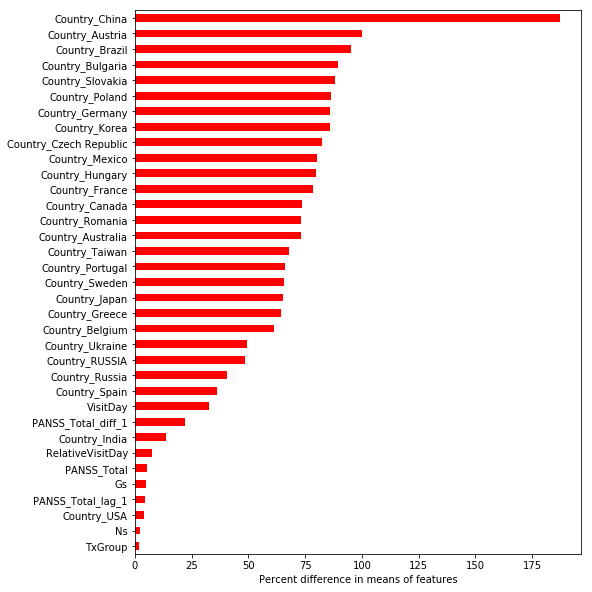

In [110]:
# visualize the difference in means of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
means = classificationDF.groupby(['LeadStatus']).mean().drop(['Country_UK'],axis=1).transpose()
means['diff'] = 100*(means[0.0]-means[1.0])/means[0.0]

Importance = pd.DataFrame({'Importance':np.abs(means['diff'])}, index=means.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,10)) 
plt.xlabel('Percent difference in means of features')

plt.gca().legend_ = None


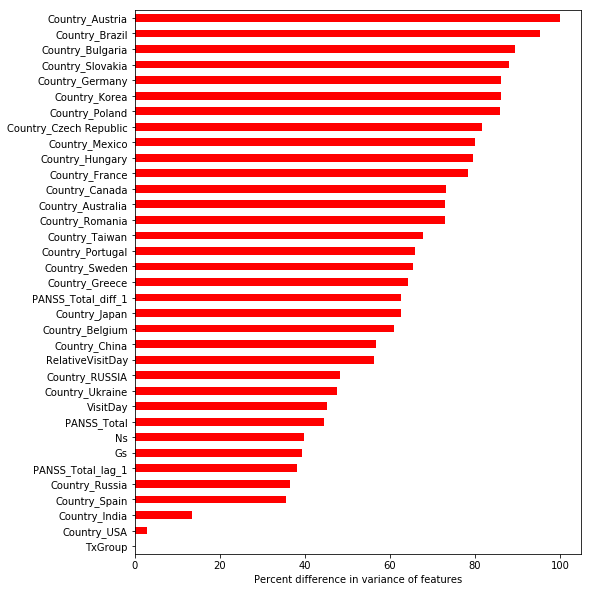

In [112]:
# visualize the difference in means of the LeadStatus groups based on the features
# have to drop UK as it is only in Study E, for whcih we do not have a lead status
variances = classificationDF.groupby(['LeadStatus']).var().drop(['Country_UK'],axis=1).transpose()
variances['diff'] = 100*(variances[0.0]-variances[1.0])/variances[0.0]

Importance = pd.DataFrame({'Importance':np.abs(variances['diff'])}, index=variances.index.values)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r',figsize=(8,10)) 
plt.xlabel('Percent difference in variance of features')

plt.gca().legend_ = None

In [207]:
from sklearn.metrics import log_loss
from sklearn import svm

testMSEs = []
trainMSEs = []
penalty = np.logspace(-3,1,5)
for i in range(5):
    # try KNN
    c = penalty[i]
    knnModel = svm.SVC(c,kernel='rbf',probability=True)
#     knnModel.fit(xTrain,yTrain)
    knnCV = cross_validate(knnModel,xTrain,yTrain['LeadStatus'],scoring='neg_log_loss')
#     #only get probs for class=1, i.e. notPassed
#     yPredTrain = knnModel.predict_proba(xTrain)[:,1]
#     trainMSEs.append(brier_score_loss(yTrain.LeadStatus,yPredTrain))
    
#     yPredTest = knnModel.predict_proba(xTest)[:,1]
    trainMSEs.append(knnCV['train_score'])
    testMSEs.append(knnCV['test_score'])

KeyboardInterrupt: 

array([0.03989412, 0.03810276, 0.03852326, 0.03454658, 0.03281613,
       0.03239015, 0.02732282, 0.02558349, 0.02593034, 0.02391903,
       0.02183601, 0.01958747, 0.01628836, 0.01456529, 0.01112283,
       0.01082704, 0.01072598, 0.00880341, 0.00723348, 0.00708668,
       0.00694711, 0.00703922, 0.00704239, 0.0070696 , 0.00720941,
       0.00731677, 0.00567946, 0.00563578, 0.00568523, 0.00426112])

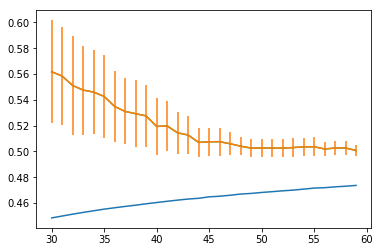

In [202]:
meanMSETrain = np.apply_along_axis(np.mean, 1, trainMSEs)
meanMSETest = np.apply_along_axis(np.mean, 1, testMSEs)
stdMSETest = np.apply_along_axis(stats.sem, 1, testMSEs)

xAxis = range(30,60,1)
plt.plot(xAxis,np.abs(meanMSETrain))
plt.errorbar(xAxis,np.abs(meanMSETest),stdMSETest)
plt.plot(xAxis,np.abs(meanMSETest))
stdMSETest

In [163]:
# try logistic regression
testMSEs = []
trainMSEs = []
for k in range(1,20,1):
    # try KNN
    knnModel = KNeighborsClassifier(k)
#     knnModel.fit(xTrain,yTrain)
    knnCV = cross_validate(knnModel,xTrain,yTrain['LeadStatus'],scoring='brier_score_loss')
#     #only get probs for class=1, i.e. notPassed
#     yPredTrain = knnModel.predict_proba(xTrain)[:,1]
#     trainMSEs.append(brier_score_loss(yTrain.LeadStatus,yPredTrain))
    
#     yPredTest = knnModel.predict_proba(xTest)[:,1]
    trainMSEs.append(np.mean(knnCV['train_score']))
    testMSEs.append(np.mean(knnCV['test_score']))

0.1279650595270677

In [ ]:
# try gradient boosting
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_cv_classifier(
    max_depth,
    learning_rate,
    min_child_weight,
    subsample,
    colsample_bytree,
    num_estimators):

    xgbModel = xgb.XGBClassifier(max_depth=int(max_depth),
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective='reg:squarederror',
                n_estimators=int(num_estimators),
                learning_rate=learning_rate,
                random_state=123).fit(xTrain,yTrain)
    
    cval = cross_val_score(xgbModel,xTrain,yTrain,scoring='neg_log_loss',cv=4)
    return cval.mean()

params={'max_depth':(2,8),
        'learning_rate':(0.0001,0.01),
        'min_child_weight':(4,11),
        'subsample':(0.1,0.99),
        'colsample_bytree':(0.1,0.99),
        'num_estimators':(1000,5000)}

optimizer = BayesianOptimization(f=xgb_cv_classifier,pbounds=params,random_state=1234,verbose=1)
#uncomment to run tuning
# optimizer.maximize(n_iter=10)



In [211]:
max_depth = int(4.560754838168456)
min_child_weight = 9.045540235624115
subsample = 0.5075516841270551
colsample_bytree = 0.9327168726669024
objective = 'binary:logistic'
num_estimators = int(2267.629207663803)
learning_rate = 0.005726562438123513

boostModel = xgb.XGBClassifier(max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                objective=objective,
                n_estimators=num_estimators,
                learning_rate=learning_rate,
                random_state=1234)
boostModelFit = boostModel.fit(xTrain,yTrain)

yPredTrain = boostModelFit.predict_proba(xTrain)[:,1]
yPredTest = boostModelFit.predict_proba(xTest)[:,1]

print("Train Log loss:"+str(log_loss(yTrain.LeadStatus,yPredTrain)))
print("Test Log loss:" +str(log_loss(yTrain.LeadStatus,yPredTrain)))

Train Log loss:0.33965700505628
Test Log loss:0.33965700505628


In [241]:

binaryClassification = boostModelFit.predict_proba(resultDF.drop(['AssessmentiD'],axis=1))[:,0]
submissionBC = pd.DataFrame(columns=['AssessmentiD','LeadStatus'])
submissionBC['AssessmentiD'] = resultDF.AssessmentiD
submissionBC['LeadStatus'] = (binaryClassification)
submissionBC.to_csv("classification_submissions/classification_submit_XGB.csv")

In [237]:
submissionBC

,AssessmentiD,LeadStatus
20947,501017,0.201785
20948,500679,0.234789
20949,500930,0.085113
20950,502177,0.097275
20951,501533,0.103366
20952,500270,0.300524
20953,501211,0.277027
20954,500597,0.147638
20955,501301,0.111488
20956,501974,0.077412


### References
1.https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
2. https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
3. https://github.com/fmfn/BayesianOptimization
